In [5]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.exposure import equalize_adapthist
from skimage.filters import unsharp_mask
from skimage.morphology import binary_closing
from skimage.morphology import binary_opening, remove_small_objects
from skimage.morphology import disk
from skimage.morphology import remove_small_holes

from src.filters import normalize_0_255
from src.models import InputImage
from src.utils import keep_largest_object
from src.utils import keep_second_largest_object
from src.well.find_well_props import find_well_props

# Searching for well properties
_____________________________________________________________
# Hough-transformation for the well
_____________________________________________________________
# Hough-transformation finished
_____________________________________________________________
# Creating circle mask for well
_____________________________________________________________
# Circle mask for well created
_____________________________________________________________
# Creating remaining masks:
_____________________________________________________________
# Creating cropped mask
_____________________________________________________________
# Creating masked image (original)
_____________________________________________________________
# Creating masked image (cropped)
_____________________________________________________________
# Created remaining masks
_____________________________________________________________
# Finished searching for well properties
_____________________________

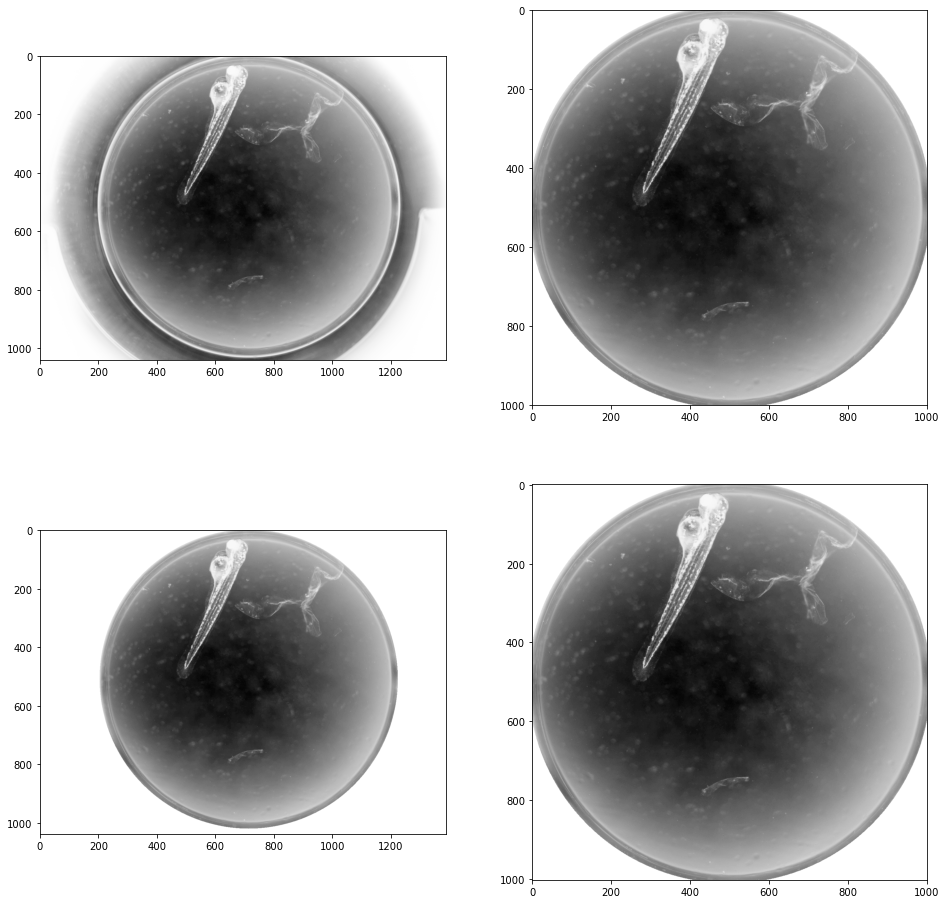

In [6]:
input_img = InputImage("zf10.czi")
input_img.processed = normalize_0_255(input_img.processed)
input_img.processed = np.uint8(input_img.processed)
input_img = find_well_props(input_img)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

ax[0].imshow(input_img.og, 'binary')
ax[1].imshow(input_img.processed, 'binary')
ax[2].imshow(input_img.well_props.mask.masked, 'binary')
ax[3].imshow(input_img.well_props.mask.cropped_masked, 'binary')

# Finding largest object
_____________________________________________________________


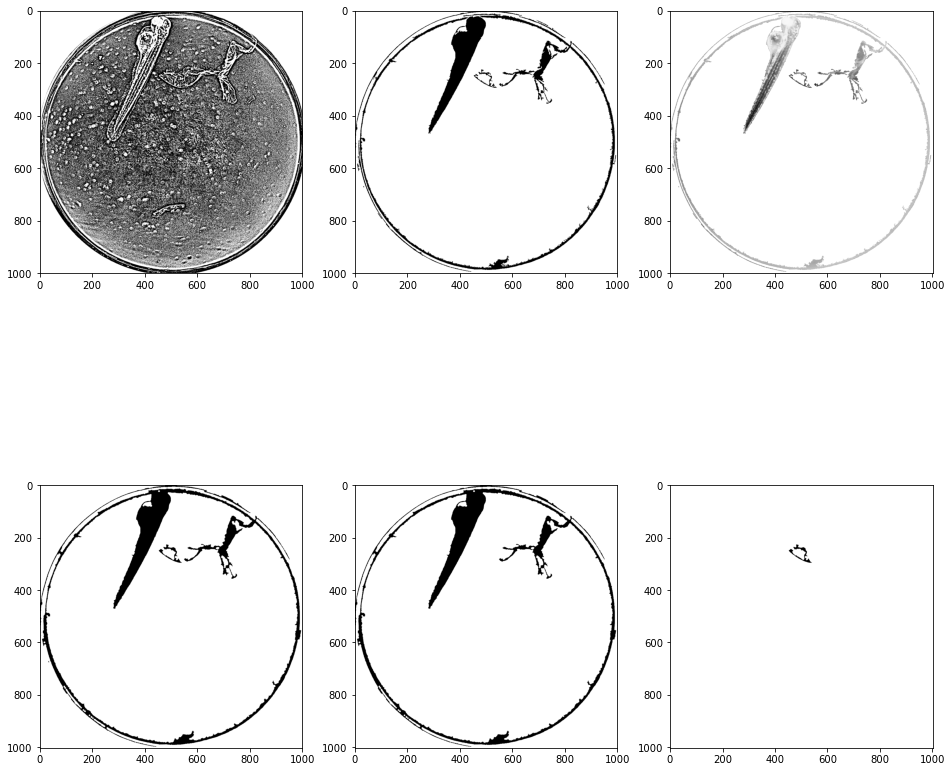

In [7]:
masked = input_img.well_props.mask.cropped_masked

unsharp_ = unsharp_mask(equalize_adapthist(masked), amount=40, radius=3)
th_ = remove_small_holes(remove_small_objects(unsharp_ < 0.25, min_size=unsharp_.size * 0.0005),
                         area_threshold=unsharp_.size * 0.01) * input_img.well_props.mask.cropped

ope = binary_opening(th_, disk(3))
ope = binary_closing(th_, disk(3))

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 16))
ax = ax.ravel()
ax[0].imshow(unsharp_, 'binary')
ax[1].imshow(th_, 'binary')
ax[2].imshow(th_ * masked, 'binary')
ax[3].imshow(ope, 'binary')
ax[4].imshow(keep_largest_object(ope), 'binary')
ax[5].imshow(keep_second_largest_object(ope), 'binary')